This flocking example is based on the following colab notebook:  
https://github.com/google/jax-md/blob/main/notebooks/flocking.ipynb

In [1]:
import jax
from IPython.display import Image as DisplayImage
from IPython.display import clear_output

!pip install evojax
clear_output()

import evojax
from evojax import Trainer
from evojax.policy import MLPPolicy
from evojax.algo import PGPE
from evojax.task import flocking
from evojax.util import create_logger

In [2]:
# Let's create a directory to save logs and models.
log_dir = './log'
logger = create_logger(name='EvoJAX', log_dir=log_dir)
logger.info('Welcome to the tutorial on Task creation!')

logger.info('Jax backend: {}'.format(jax.local_devices()))
!nvidia-smi --query-gpu=name --format=csv,noheader

EvoJAX: 2022-03-29 06:51:32,645 [INFO] Welcome to the tutorial on Task creation!
absl: 2022-03-29 06:51:32,653 [INFO] Starting the local TPU driver.
absl: 2022-03-29 06:51:32,654 [INFO] Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
absl: 2022-03-29 06:51:32,817 [INFO] Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
EvoJAX: 2022-03-29 06:51:32,818 [INFO] Jax backend: [GpuDevice(id=0, process_index=0)]


NVIDIA A100-SXM4-40GB


# Compare Reward Functions
In task/flocking, the reward function can be selected at init.  

- When reward_type = 0  
Normal reward function.

- When reward_type = 1  
Make the reward greater as the step in each iteration goes to the later part.

Let's look at the difference between two reward functions.

## Normal reward function

In [3]:
seed = 42
neighbor_num = 5

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = flocking.FlockingTask(150, reward_type=0)
test_task = flocking.FlockingTask(150, reward_type=0)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-29 06:51:35,151 [INFO] MLPPolicy.num_params = 2321
EvoJAX: 2022-03-29 06:51:35,255 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-29 06:51:39,248 [INFO] Iter=10, size=64, max=-127.7900, avg=-146.4117, min=-165.4250, std=8.0690
EvoJAX: 2022-03-29 06:51:39,752 [INFO] Iter=20, size=64, max=-128.7990, avg=-149.7366, min=-214.1909, std=16.6223
EvoJAX: 2022-03-29 06:51:40,223 [INFO] Iter=30, size=64, max=-124.8118, avg=-133.1313, min=-161.8011, std=6.3649
EvoJAX: 2022-03-29 06:51:42,158 [INFO] [TEST] Iter=30, #tests=10, max=-111.1290 avg=-126.1089, min=-147.3589, std=10.3716
EvoJAX: 2022-03-29 06:51:42,745 [INFO] Iter=40, size=64, max=-123.5997, avg=-136.2783, min=-154.6479, std=5.8608
EvoJAX: 2022-03-29 06:51:43,216 [INFO] Iter=50, size=64, max=-127.3910, avg=-140.4068, min=-161.9044, std=7.4548
EvoJAX: 2022-03-29 06:51:43,703 [INFO] Iter=60, size=64, max=-121.8569, avg=-130.2604, min=-150.1369, std=5.0782
EvoJAX: 2022-03-29 06:51:43,750 [INFO] [TEST] Iter=60, #te

reward=[-116.0844]


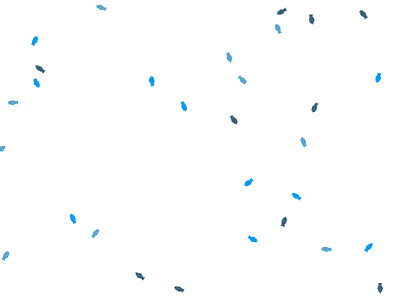

In [4]:
def render(task, algo, policy):

    state_list = []

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [flocking.FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        state_list.append(task_s.state[0])
        step += 1
        reward = reward + r
        images.append(flocking.FlockingTask.render(task_s, 0))
    state_list.append(task_s.state[0])
    print('reward={}'.format(reward))
    return images, state_list


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs, state_list1 = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

You can see fish that are stuck together and unable to leave.  
This is a sign they are not learning well.

## Larger Future Rewards

In [5]:
seed = 42
neighbor_num = 5

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = flocking.FlockingTask(150, 1)
test_task = flocking.FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-29 06:54:40,935 [INFO] MLPPolicy.num_params = 2321
EvoJAX: 2022-03-29 06:54:41,018 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-29 06:54:42,711 [INFO] Iter=10, size=64, max=-34.6810, avg=-48.0137, min=-59.7731, std=4.9891
EvoJAX: 2022-03-29 06:54:43,188 [INFO] Iter=20, size=64, max=-38.3265, avg=-46.2025, min=-73.0190, std=6.2058
EvoJAX: 2022-03-29 06:54:43,659 [INFO] Iter=30, size=64, max=-36.7396, avg=-40.9785, min=-52.4116, std=3.2609
EvoJAX: 2022-03-29 06:54:44,780 [INFO] [TEST] Iter=30, #tests=10, max=-32.7647 avg=-36.6112, min=-43.2537, std=3.2469
EvoJAX: 2022-03-29 06:54:45,289 [INFO] Iter=40, size=64, max=-36.0466, avg=-41.5579, min=-50.8511, std=3.4881
EvoJAX: 2022-03-29 06:54:45,761 [INFO] Iter=50, size=64, max=-36.0223, avg=-42.3165, min=-55.9317, std=4.7263
EvoJAX: 2022-03-29 06:54:46,266 [INFO] Iter=60, size=64, max=-34.5746, avg=-39.0043, min=-51.8323, std=4.1976
EvoJAX: 2022-03-29 06:54:46,319 [INFO] [TEST] Iter=60, #tests=10, max=-31.9202 av

reward=[-30.111736]


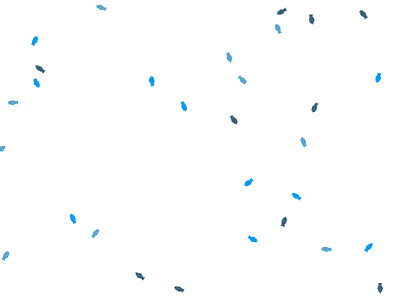

In [6]:
def render(task, algo, policy):

    state_list = []

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [flocking.FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        state_list.append(task_s.state[0])
        step += 1
        reward = reward + r
        images.append(flocking.FlockingTask.render(task_s, 0))
    state_list.append(task_s.state[0])
    print('reward={}'.format(reward))
    return images, state_list


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs, state_list2 = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking2.gif')
DisplayImage('flocking2.gif', format='png')

Each fish can now swim while keeping the proper distance.

# Change Parameters
Flocking task has many parameters. Let's change some of them.

## Observation
In this task, the fishes observe the states of the nearest 5 fishes in default.  
If they are changed to other values, let's see what happens.

### M = 3

In [7]:
seed = 42
neighbor_num = 3
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = flocking.FlockingTask(150, 1)
test_task = flocking.FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-29 06:57:44,223 [INFO] MLPPolicy.num_params = 2081
EvoJAX: 2022-03-29 06:57:44,325 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-29 06:57:46,543 [INFO] Iter=10, size=64, max=-34.5466, avg=-45.8520, min=-72.4757, std=8.4337
EvoJAX: 2022-03-29 06:57:47,016 [INFO] Iter=20, size=64, max=-34.5002, avg=-37.6745, min=-42.6221, std=1.9477
EvoJAX: 2022-03-29 06:57:47,502 [INFO] Iter=30, size=64, max=-32.6757, avg=-35.0699, min=-42.3416, std=1.7584
EvoJAX: 2022-03-29 06:57:48,616 [INFO] [TEST] Iter=30, #tests=10, max=-28.4822 avg=-31.5661, min=-41.2948, std=3.8536
EvoJAX: 2022-03-29 06:57:49,099 [INFO] Iter=40, size=64, max=-31.4904, avg=-33.9769, min=-38.5435, std=1.6301
EvoJAX: 2022-03-29 06:57:49,576 [INFO] Iter=50, size=64, max=-31.9728, avg=-34.2881, min=-39.4741, std=1.4072
EvoJAX: 2022-03-29 06:57:50,044 [INFO] Iter=60, size=64, max=-31.1566, avg=-32.9461, min=-36.9829, std=1.0488
EvoJAX: 2022-03-29 06:57:50,096 [INFO] [TEST] Iter=60, #tests=10, max=-28.7233 av

reward=[-29.39981]


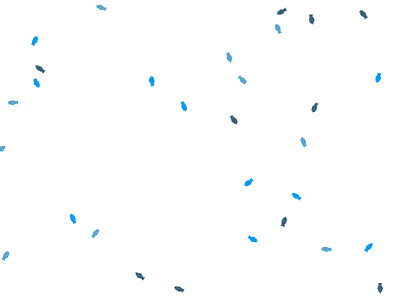

In [8]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [flocking.FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(flocking.FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

### M=7

In [9]:
seed = 42
neighbor_num = 7
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = flocking.FlockingTask(150, 1)
test_task = flocking.FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-29 07:00:47,039 [INFO] MLPPolicy.num_params = 2561
EvoJAX: 2022-03-29 07:00:47,141 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-29 07:00:49,387 [INFO] Iter=10, size=64, max=-38.0263, avg=-44.3599, min=-52.5114, std=3.3828
EvoJAX: 2022-03-29 07:00:49,873 [INFO] Iter=20, size=64, max=-37.9464, avg=-43.4288, min=-49.8061, std=2.9594
EvoJAX: 2022-03-29 07:00:50,351 [INFO] Iter=30, size=64, max=-36.4179, avg=-41.3283, min=-49.1213, std=2.2481
EvoJAX: 2022-03-29 07:00:51,565 [INFO] [TEST] Iter=30, #tests=10, max=-35.5354 avg=-39.9702, min=-47.7387, std=3.2152
EvoJAX: 2022-03-29 07:00:52,048 [INFO] Iter=40, size=64, max=-36.6607, avg=-40.6081, min=-47.5247, std=2.2370
EvoJAX: 2022-03-29 07:00:52,531 [INFO] Iter=50, size=64, max=-36.4391, avg=-41.0231, min=-48.4399, std=2.1985
EvoJAX: 2022-03-29 07:00:53,010 [INFO] Iter=60, size=64, max=-36.3616, avg=-39.7288, min=-46.6843, std=1.6152
EvoJAX: 2022-03-29 07:00:53,058 [INFO] [TEST] Iter=60, #tests=10, max=-34.5097 av

reward=[-38.01668]


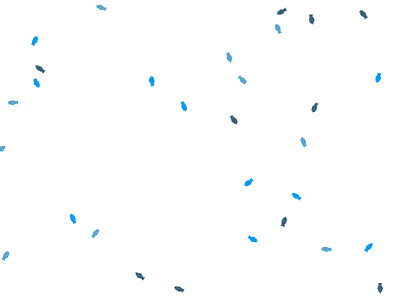

In [10]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [flocking.FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(flocking.FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

### M = 9

In [11]:
seed = 42
neighbor_num = 9
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = flocking.FlockingTask(150, 1)
test_task = flocking.FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-29 07:03:52,185 [INFO] MLPPolicy.num_params = 2801
EvoJAX: 2022-03-29 07:03:52,290 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-29 07:03:54,566 [INFO] Iter=10, size=64, max=-40.1510, avg=-46.4492, min=-52.8467, std=3.0338
EvoJAX: 2022-03-29 07:03:55,060 [INFO] Iter=20, size=64, max=-38.9034, avg=-44.8300, min=-53.7918, std=2.8942
EvoJAX: 2022-03-29 07:03:55,547 [INFO] Iter=30, size=64, max=-36.8804, avg=-43.5749, min=-49.0877, std=2.9294
EvoJAX: 2022-03-29 07:03:56,686 [INFO] [TEST] Iter=30, #tests=10, max=-33.3312 avg=-42.2650, min=-53.3492, std=5.0290
EvoJAX: 2022-03-29 07:03:57,189 [INFO] Iter=40, size=64, max=-39.1224, avg=-44.8099, min=-50.7646, std=2.8019
EvoJAX: 2022-03-29 07:03:57,677 [INFO] Iter=50, size=64, max=-39.6840, avg=-44.1770, min=-48.8659, std=2.0249
EvoJAX: 2022-03-29 07:03:58,176 [INFO] Iter=60, size=64, max=-39.0713, avg=-43.8319, min=-50.6449, std=2.5060
EvoJAX: 2022-03-29 07:03:58,223 [INFO] [TEST] Iter=60, #tests=10, max=-35.0148 av

reward=[-40.179253]


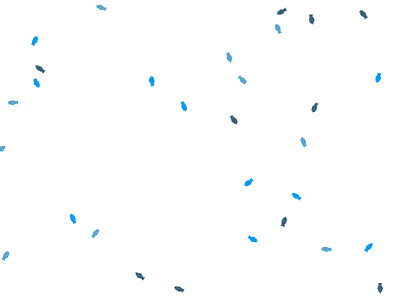

In [12]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [flocking.FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(flocking.FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

### M = 11

In [13]:
seed = 42
neighbor_num = 11
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = flocking.FlockingTask(150, 1)
test_task = flocking.FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-29 07:06:58,486 [INFO] MLPPolicy.num_params = 3041
EvoJAX: 2022-03-29 07:06:58,595 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-29 07:07:01,019 [INFO] Iter=10, size=64, max=-34.4437, avg=-40.6592, min=-49.2614, std=3.2035
EvoJAX: 2022-03-29 07:07:01,539 [INFO] Iter=20, size=64, max=-35.9301, avg=-38.8945, min=-49.5575, std=2.1753
EvoJAX: 2022-03-29 07:07:02,038 [INFO] Iter=30, size=64, max=-34.7116, avg=-37.5491, min=-45.2136, std=1.5796
EvoJAX: 2022-03-29 07:07:03,401 [INFO] [TEST] Iter=30, #tests=10, max=-32.7755 avg=-36.4195, min=-46.4112, std=3.9580
EvoJAX: 2022-03-29 07:07:03,903 [INFO] Iter=40, size=64, max=-35.7868, avg=-38.8447, min=-44.0920, std=1.6652
EvoJAX: 2022-03-29 07:07:04,415 [INFO] Iter=50, size=64, max=-36.1793, avg=-38.9095, min=-41.5711, std=1.2330
EvoJAX: 2022-03-29 07:07:04,914 [INFO] Iter=60, size=64, max=-35.2319, avg=-37.8992, min=-42.5144, std=1.4610
EvoJAX: 2022-03-29 07:07:04,964 [INFO] [TEST] Iter=60, #tests=10, max=-31.5300 av

reward=[-37.734257]


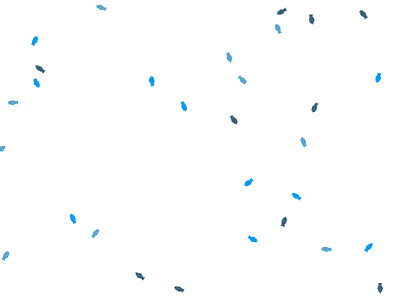

In [14]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [flocking.FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(flocking.FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

If we set M too large, the learning process will not proceed well.  
It turns out that they behave completely differently depending on the NEIGHBOR_NUM.

# 

## Allowable angle of rotation
If the allowable angle of rotation of each step were increased, collisions might be easier to avoid.
Let's try it.

In [15]:
seed = 42
neighbor_num = 5
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num
evojax.task.flocking.SPEED = 0.025
evojax.task.flocking.DT = 0.6

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = flocking.FlockingTask(150, 1)
test_task = flocking.FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[40, 40],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-29 07:10:00,868 [INFO] MLPPolicy.num_params = 2321
EvoJAX: 2022-03-29 07:10:00,940 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-29 07:10:02,654 [INFO] Iter=10, size=64, max=-40.2273, avg=-55.9631, min=-139.0797, std=16.0353
EvoJAX: 2022-03-29 07:10:03,127 [INFO] Iter=20, size=64, max=-45.6727, avg=-57.2404, min=-79.4085, std=6.5589
EvoJAX: 2022-03-29 07:10:03,615 [INFO] Iter=30, size=64, max=-41.0941, avg=-46.5215, min=-81.2813, std=5.8590
EvoJAX: 2022-03-29 07:10:04,776 [INFO] [TEST] Iter=30, #tests=10, max=-37.8014 avg=-45.0531, min=-48.6468, std=3.2096
EvoJAX: 2022-03-29 07:10:05,254 [INFO] Iter=40, size=64, max=-39.9814, avg=-46.8460, min=-76.4881, std=6.9163
EvoJAX: 2022-03-29 07:10:05,727 [INFO] Iter=50, size=64, max=-41.7705, avg=-47.5499, min=-72.5385, std=4.6918
EvoJAX: 2022-03-29 07:10:06,199 [INFO] Iter=60, size=64, max=-47.1713, avg=-52.6043, min=-61.0615, std=3.2920
EvoJAX: 2022-03-29 07:10:06,248 [INFO] [TEST] Iter=60, #tests=10, max=-37.2471 

reward=[-41.56988]


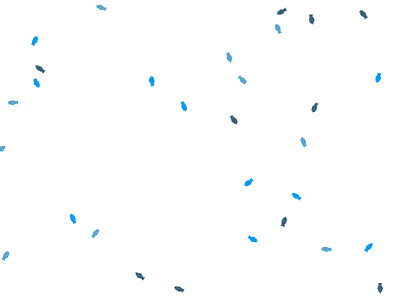

In [16]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [flocking.FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(flocking.FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

Unintentionally, they have learned to rotate on the spot.  
This is certainly less collision, and if they rotate at exactly the same timing, Alignment may be possible. 

## Learning Speed
In task/flocking, not only angles but also speed can be learned.  
To do this, set the action_type to 1 at initialization.   
Learning speed may help to avoid collisions and to align more neatly. Let's give it a try.

In [17]:
seed = 42
neighbor_num = 5

evojax.task.flocking.NEIGHBOR_NUM = neighbor_num
evojax.task.flocking.SPEED = 0.12
evojax.task.flocking.DT = 0.2

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = flocking.FlockingTask(150, 1, action_type=1)
test_task = flocking.FlockingTask(150, 1, action_type=1)

policy = MLPPolicy(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[40, 40],
    output_dim=train_task.act_shape[0],
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-29 07:13:00,467 [INFO] MLPPolicy.num_params = 2362
EvoJAX: 2022-03-29 07:13:00,535 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-29 07:13:02,887 [INFO] Iter=10, size=64, max=-37.2692, avg=-43.4441, min=-53.6798, std=3.3131
EvoJAX: 2022-03-29 07:13:03,403 [INFO] Iter=20, size=64, max=-33.2977, avg=-41.5715, min=-50.9964, std=4.0649
EvoJAX: 2022-03-29 07:13:03,921 [INFO] Iter=30, size=64, max=-31.5969, avg=-35.7203, min=-42.6225, std=2.1773
EvoJAX: 2022-03-29 07:13:05,166 [INFO] [TEST] Iter=30, #tests=10, max=-31.3423 avg=-33.0192, min=-37.4813, std=1.7627
EvoJAX: 2022-03-29 07:13:05,683 [INFO] Iter=40, size=64, max=-28.5281, avg=-31.6291, min=-35.4481, std=1.5904
EvoJAX: 2022-03-29 07:13:06,219 [INFO] Iter=50, size=64, max=-27.7900, avg=-29.9976, min=-36.5329, std=1.8514
EvoJAX: 2022-03-29 07:13:06,750 [INFO] Iter=60, size=64, max=-27.1294, avg=-29.5485, min=-39.1416, std=2.3828
EvoJAX: 2022-03-29 07:13:06,802 [INFO] [TEST] Iter=60, #tests=10, max=-26.4851 av

reward=[-25.960072]


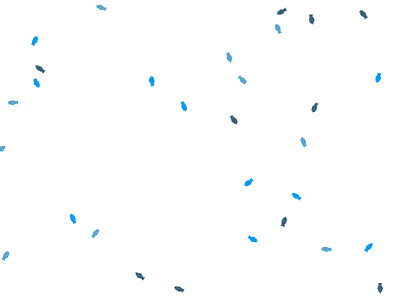

In [18]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [flocking.FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(flocking.FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

We saw a cleaner animation than in the first example.  
By changing the parameters, we may be able to see more interesting behaviors.